<a href="https://colab.research.google.com/github/losirlu1411/project-/blob/main/tuberculosis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### 1. Imports and Configuration
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import VGG16, DenseNet201, ResNet101
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:

# Dataset path
base_path = '/content/drive/MyDrive/project /TB_Chest_Radiography_Database'

# Class labels
labels = ['Normal', 'Tuberculosis']
image_size = 224

In [3]:
### 2. Data Loading and Preprocessing
# Function to load and preprocess images with optional sampling
def load_data(base_path, labels, image_size, sample_size):
    data, label_list = [], []
    for label_idx, label in enumerate(labels):
        folder_path = os.path.join(base_path, label)
        all_files = os.listdir(folder_path)
        if sample_size:
            sampled_files = random.sample(all_files, min(len(all_files), sample_size))
        else:
            sampled_files = all_files
        for file_name in sampled_files:
            img_path = os.path.join(folder_path, file_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            data.append(img)
            label_list.append(label_idx)
    return np.array(data), np.array(label_list)



In [4]:
# Load dataset with all samples
print("Loading full dataset...")
x_data_full, y_data_full = load_data(base_path, labels, image_size,sample_size=None)
x_data_full = x_data_full / 255.0  # Normalize images
y_data_full = to_categorical(y_data_full, num_classes=len(labels))  # One-hot encode labels
print(f"Total images loaded: {len(x_data_full)}")



Loading full dataset...
Total images loaded: 4210


In [5]:
# Split into train and test sets for both datasets
x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(x_data_full, y_data_full, test_size=0.2, random_state=42)


In [6]:
### 3. Class Weights and Data Augmentation
# Compute class weights for both datasets
class_weights_full = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train_full, axis=1)),
    y=np.argmax(y_train_full, axis=1)
)
class_weights_dict_full = {i: weight for i, weight in enumerate(class_weights_full)}

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_datagen.fit(x_train_full)


In [7]:
### 4. Model Building
# Function to build a custom CNN model
def build_custom_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        # Changed the third Conv2D layer configuration from 128 filters with (3,3) kernel to 64 filters with (3,3) kernel.
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

# Function to build pretrained models
def build_pretrained_model(base_model, input_shape, num_classes):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

In [8]:
### 5. Training and Evaluation Framework
# Function to train and evaluate model
def train_and_evaluate_model(model, model_name, x_train, y_train, x_test, y_test, datagen, class_weights):
    print(f"Training {model_name}...")
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        validation_data=(x_test, y_test),
        epochs=20,
        class_weight=class_weights,
        callbacks=[early_stopping],
        verbose=1
    )
    print(f"Evaluating {model_name}...")
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return history

Training Custom CNN (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 46s 350ms/step - accuracy: 0.6507 - loss: 0.8183 - recall: 0.4541 - val_accuracy: 0.9169 - val_loss: 0.3950 - val_recall: 0.5036
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 289ms/step - accuracy: 0.8545 - loss: 0.5441 - recall: 0.5970 - val_accuracy: 0.9121 - val_loss: 0.3454 - val_recall: 0.4964
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 289ms/step - accuracy: 0.8575 - loss: 0.4923 - recall: 0.7318 - val_accuracy: 0.9287 - val_loss: 0.3334 - val_recall: 0.7007
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 287ms/step - accuracy: 0.8832 - loss: 0.4162 - recall: 0.8430 - val_accuracy: 0.9371 - val_loss: 0.3245 - val_recall: 0.9051
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 289ms/step - accuracy: 0.8932 - loss: 0.3968 - recall: 0.8717 - val_accuracy: 0.9371 - val_loss: 0.3213 - val_recall: 0.8175
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 289ms/step - accuracy: 0.9017 - loss: 0.3889 - recall: 0.8904 - val_accuracy: 0.9549 - val_loss: 0.3144 - val_recall: 0.90

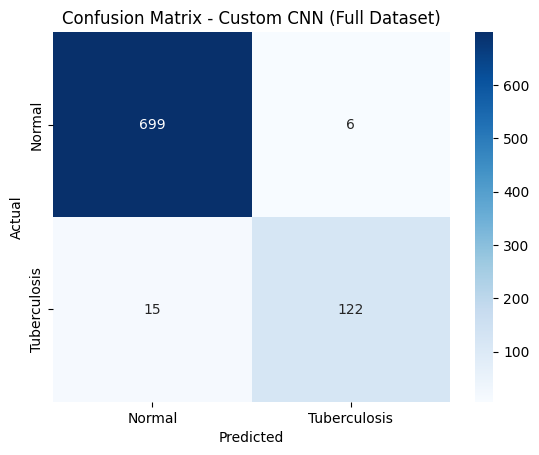

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training VGG16 (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - accuracy: 0.7294 - loss: 1.2239 - recall: 0.6943 - val_accuracy: 0.9228 - val_loss: 0.3241 - val_recall: 0.9635
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 290ms/step - accuracy: 0.8952 - loss: 0.3888 - recall: 0.8779 - val_accuracy: 0.9228 - val_loss: 0.3243 - val_recall: 0.9781
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 292ms/step - accuracy: 0.8953 - loss: 0.3856 - recall: 0.9084 - val_accuracy: 0.9679 - val_loss: 0.2698 - val_recall: 0.9635
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 290ms/step - accuracy: 0.8866 - loss: 0.3958 - recall: 0.9135 - val_accuracy: 0.9834 - val_loss: 0.2486 - val_recall: 0.9562
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 291ms/step - accuracy: 0.9204 - loss: 0.3685 - recall: 0.9043 - val_accuracy: 0.9929 - val_loss: 0.2389 - val_recall: 0.9635
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 290ms/step - accuracy: 0.9222 - loss: 0.3583 - recall: 0.8803 - val_accuracy: 0.9857 - val_loss: 0.2474 - val_recall: 0.96

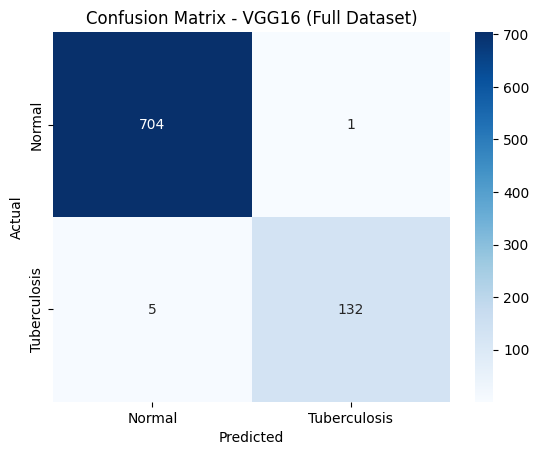

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training DenseNet201 (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 117s 723ms/step - accuracy: 0.7726 - loss: 3.7913 - recall: 0.7626 - val_accuracy: 0.9822 - val_loss: 0.2607 - val_recall: 0.9343
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 300ms/step - accuracy: 0.9144 - loss: 0.3627 - recall: 0.8989 - val_accuracy: 0.9893 - val_loss: 0.2513 - val_recall: 0.9562
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.9357 - loss: 0.3392 - recall: 0.9336 - val_accuracy: 0.9881 - val_loss: 0.2407 - val_recall: 0.9270
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 299ms/step - accuracy: 0.9422 - loss: 0.3294 - recall: 0.9347 - val_accuracy: 0.9941 - val_loss: 0.2399 - val_recall: 0.9635
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 35s 307ms/step - accuracy: 0.9554 - loss: 0.3197 - recall: 0.9517 - val_accuracy: 0.9964 - val_loss: 0.2325 - val_recall: 0.9781
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.9625 - loss: 0.3043 - recall: 0.9622 - val_accuracy: 0.9869 - val_loss: 0.2455 - val_recall: 0.9

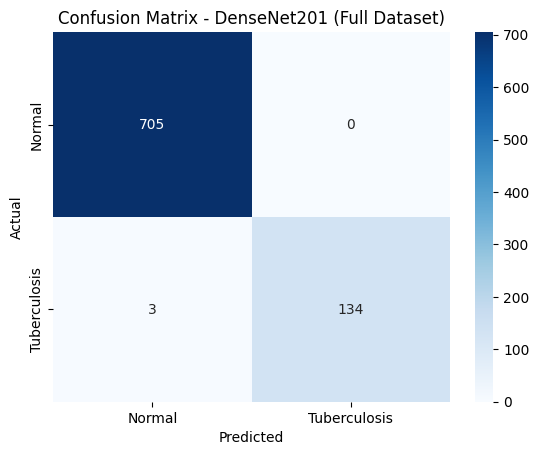

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Training ResNet101 (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 67s 442ms/step - accuracy: 0.5411 - loss: 3.9098 - recall: 0.4444 - val_accuracy: 0.1627 - val_loss: 0.6942 - val_recall: 1.0000
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.2215 - loss: 0.6935 - recall: 0.8852 - val_accuracy: 0.1627 - val_loss: 0.6939 - val_recall: 1.0000
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.3100 - loss: 0.6952 - recall: 0.7929 - val_accuracy: 0.8385 - val_loss: 0.6925 - val_recall: 0.0073
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.2805 - loss: 0.7106 - recall: 0.7761 - val_accuracy: 0.8385 - val_loss: 0.6921 - val_recall: 0.0073
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - accuracy: 0.4086 - loss: 0.7010 - recall: 0.6026 - val_accuracy: 0.1627 - val_loss: 0.6938 - val_recall: 1.0000
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.2447 - loss: 0.6959 - recall: 0.8877 - val_accuracy: 0.8385 - val_loss: 0.6886 - val_recall: 0.00

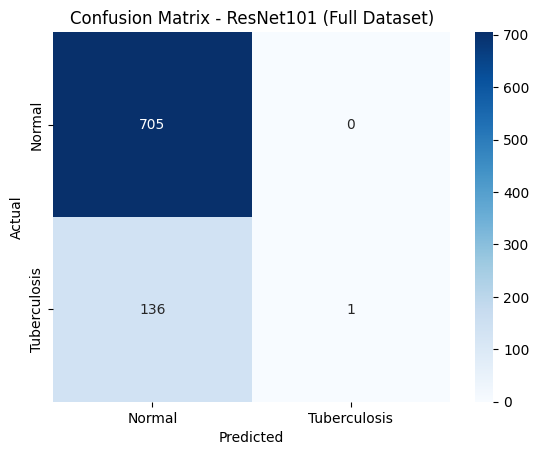

In [9]:
### 6. Model Training
# Define input shape and number of classes
input_shape = (image_size, image_size, 3)
num_classes = len(labels)

# Custom Model
custom_model_full = build_custom_model(input_shape, num_classes)
custom_history_full = train_and_evaluate_model(custom_model_full, "Custom CNN (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)


# VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_model_full = build_pretrained_model(vgg16_base, input_shape, num_classes)
vgg16_history_full = train_and_evaluate_model(vgg16_model_full, "VGG16 (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)

# DenseNet201
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_model_full = build_pretrained_model(densenet_base, input_shape, num_classes)
densenet_history_full = train_and_evaluate_model(densenet_model_full, "DenseNet201 (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)

# ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_model_full = build_pretrained_model(resnet_base, input_shape, num_classes)
resnet_history_full = train_and_evaluate_model(resnet_model_full, "ResNet101 (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)


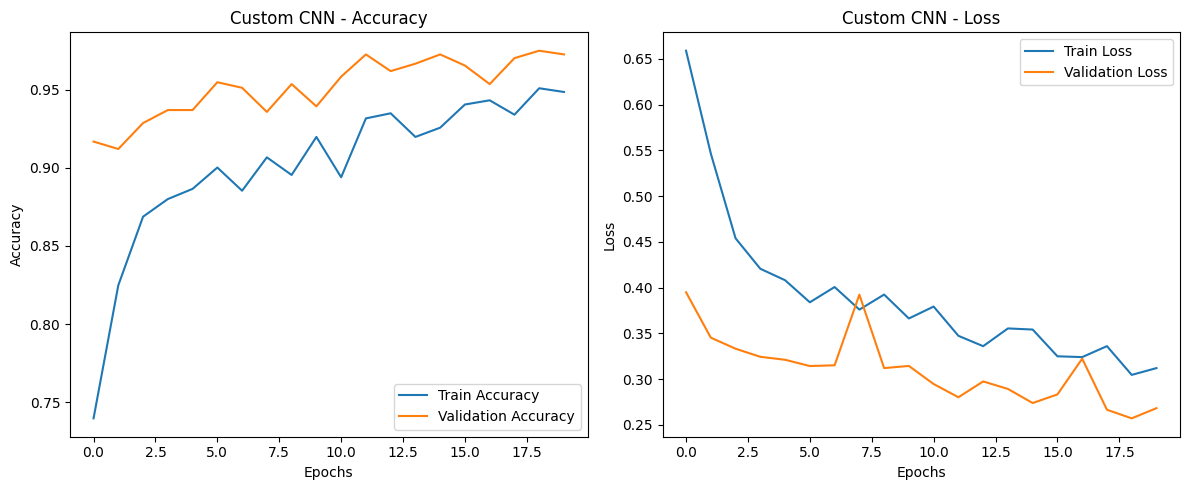

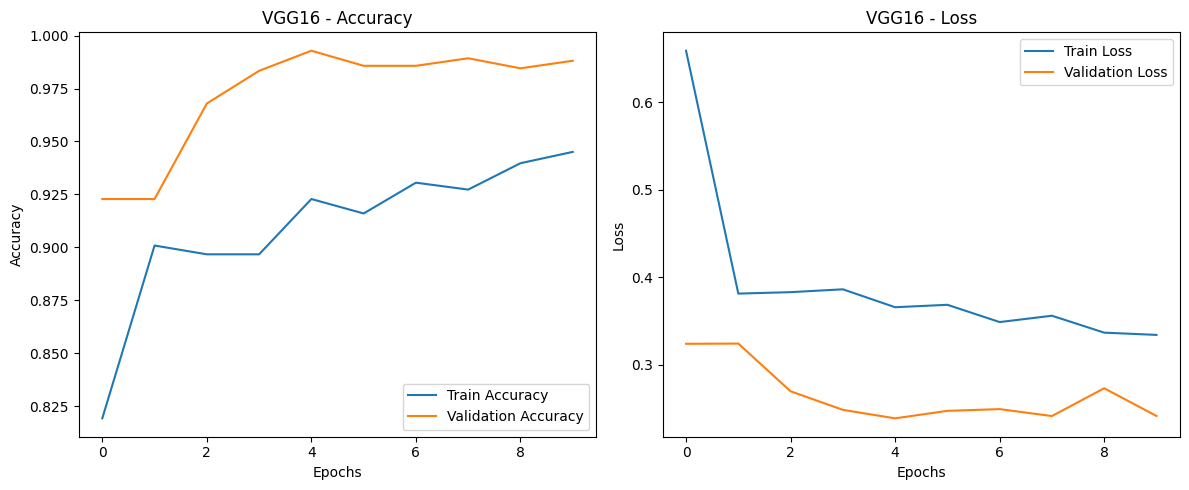

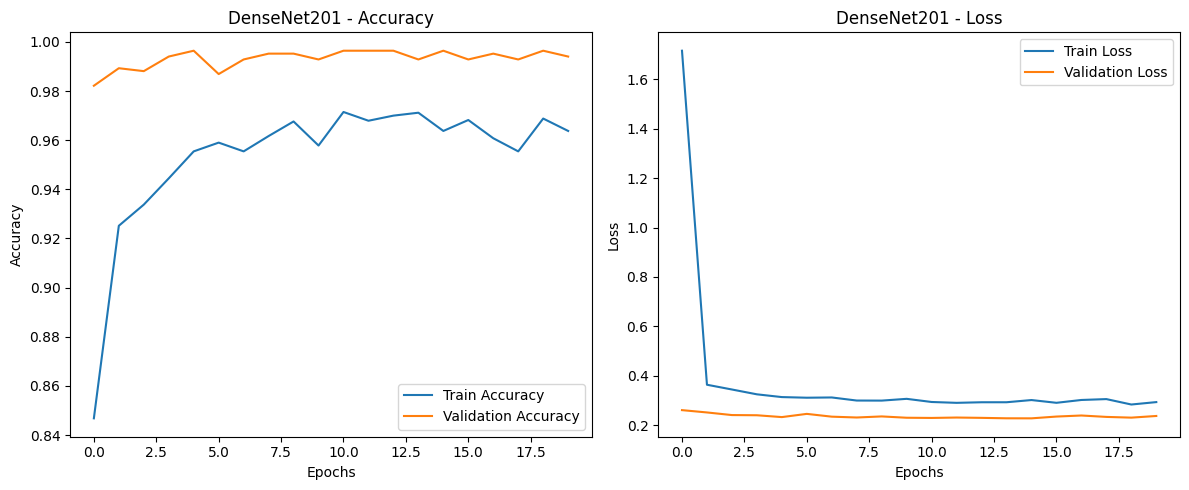

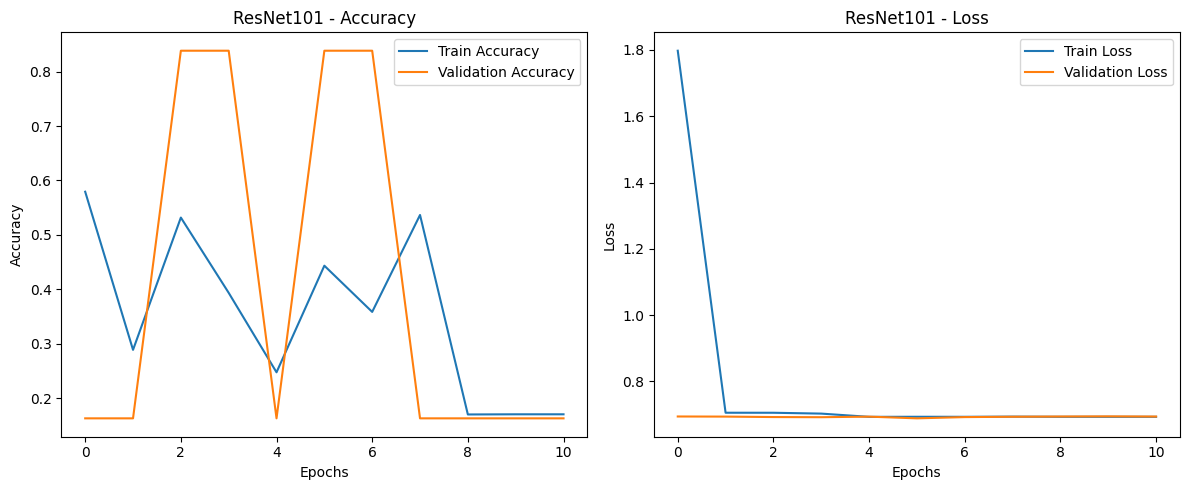

In [10]:
# 7 Plot individual models
models = {
    "Custom CNN": custom_history_full,
    "VGG16": vgg16_history_full,
    "DenseNet201": densenet_history_full,
    "ResNet101": resnet_history_full,

}

for model_name, history in models.items():
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Predictions for Full Dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


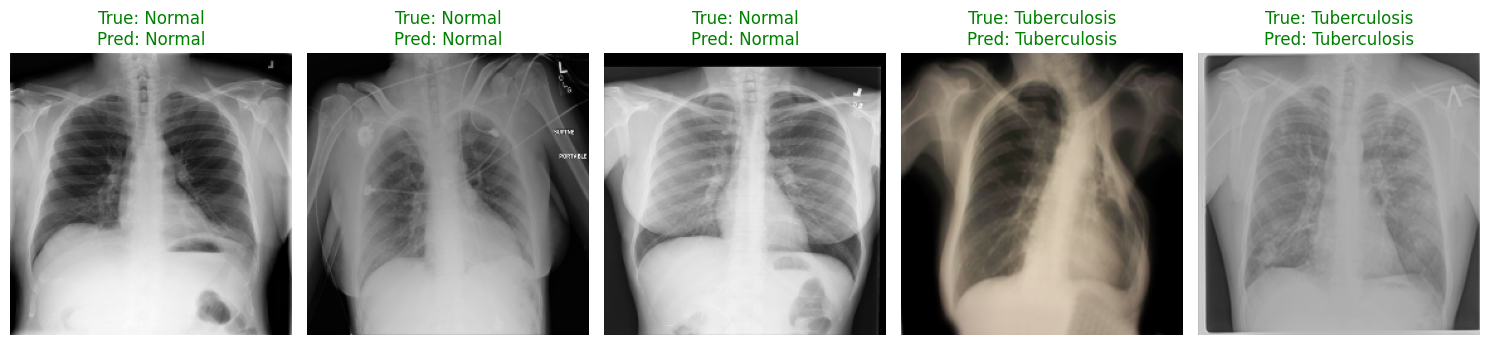

In [11]:
### 8. Predict and Display Images
# Function to display predictions for 5 random images
def display_predictions(model, x_test, y_test, labels, num_images=5):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        img = x_test[idx]
        true_label = labels[np.argmax(y_test[idx])]
        pred_label = labels[np.argmax(model.predict(img[np.newaxis, ...]))]
        color = 'green' if true_label == pred_label else 'red'
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
print("Predictions for Full Dataset")
display_predictions(custom_model_full, x_test_full, y_test_full, labels, num_images=5)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


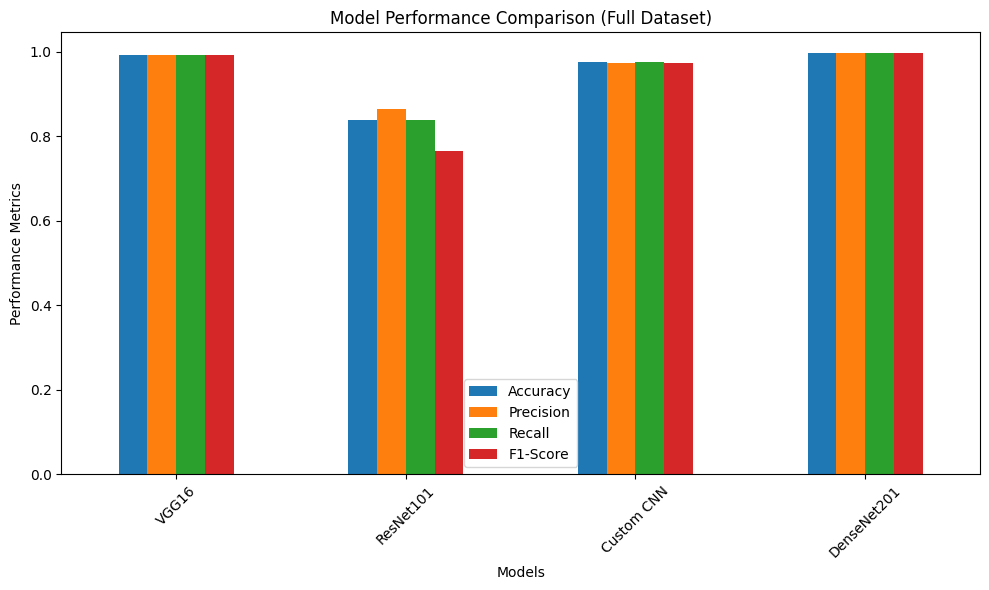

In [12]:
# 9 Predictions for each individual model
vgg_preds_full = np.argmax(vgg16_model_full.predict(x_test_full), axis=1)
resnet_preds_full = np.argmax(resnet_model_full.predict(x_test_full), axis=1)
custom_preds_full = np.argmax(custom_model_full.predict(x_test_full), axis=1)
densenet_preds_full = np.argmax(densenet_model_full.predict(x_test_full), axis=1)

# True labels
y_true_full = np.argmax(y_test_full, axis=1)

# Ensemble model predictions (majority voting)
ensemble_preds_full = []
for i in range(len(vgg_preds_full)):
    preds = [vgg_preds_full[i], resnet_preds_full[i], custom_preds_full[i]]
    ensemble_preds_full.append(max(set(preds), key=preds.count))

#ensemble_preds_sampled = []
#for i in range(len(vgg_preds_sampled)):
   # preds = [vgg_preds_sampled[i], resnet_preds_sampled[i], custom_preds_sampled[i]]
    #ensemble_preds_sampled.append(max(set(preds), key=preds.count))

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}

# Evaluate models for the full dataset
results_full = []
results_full.append(evaluate_model(y_true_full, vgg_preds_full, "VGG16"))
results_full.append(evaluate_model(y_true_full, resnet_preds_full, "ResNet101"))
results_full.append(evaluate_model(y_true_full, custom_preds_full, "Custom CNN"))
results_full.append(evaluate_model(y_true_full, densenet_preds_full, "DenseNet201"))

# Convert results to DataFrames for comparison
results_full_df = pd.DataFrame(results_full)

# Bar plot for the full dataset
results_full_df.set_index("Model").plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison (Full Dataset)")
plt.xlabel("Models")
plt.ylabel("Performance Metrics")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()



In [13]:
# Load dataset with 500 samples per class
print("Loading sampled dataset (500 per class)...")
x_data_sampled, y_data_sampled = load_data(base_path, labels, image_size, sample_size=500)
x_data_sampled = x_data_sampled / 255.0  # Normalize images
y_data_sampled = to_categorical(y_data_sampled, num_classes=len(labels))  # One-hot encode labels
print(f"Total images loaded: {len(x_data_sampled)}")

Loading sampled dataset (500 per class)...
Total images loaded: 1000


In [14]:
# Split into train and test sets for both datasets
x_train_sampled, x_test_sampled, y_train_sampled, y_test_sampled = train_test_split(x_data_sampled, y_data_sampled, test_size=0.2, random_state=42)

In [15]:
### 3. Class Weights and Data Augmentation
# Compute class weights for both datasets

class_weights_sampled = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train_sampled, axis=1)),
    y=np.argmax(y_train_sampled, axis=1)
)
class_weights_dict_sampled = {i: weight for i, weight in enumerate(class_weights_sampled)}

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_datagen.fit(x_train_sampled)

In [16]:
### 4. Model Building
# Function to build a custom CNN model
def build_custom_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        # Changed the third Conv2D layer configuration from 128 filters with (3,3) kernel to 64 filters with (3,3) kernel.
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

# Function to build pretrained models
def build_pretrained_model(base_model, input_shape, num_classes):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

In [17]:
### 5. Training and Evaluation Framework
# Function to train and evaluate model
def train_and_evaluate_model(model, model_name, x_train, y_train, x_test, y_test, datagen, class_weights):
    print(f"Training {model_name}...")
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        validation_data=(x_test, y_test),
        epochs=20,
        class_weight=class_weights,
        callbacks=[early_stopping],
        verbose=1
    )
    print(f"Evaluating {model_name}...")
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return history

Training Custom CNN (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step - accuracy: 0.5722 - loss: 1.3004 - recall: 0.5148 - val_accuracy: 0.7200 - val_loss: 0.6474 - val_recall: 0.4615
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.6853 - loss: 0.6287 - recall: 0.6224 - val_accuracy: 0.6900 - val_loss: 0.9315 - val_recall: 0.4038
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.7909 - loss: 0.5340 - recall: 0.6358 - val_accuracy: 0.7200 - val_loss: 0.5156 - val_recall: 0.4712
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.8038 - loss: 0.4732 - recall: 0.7161 - val_accuracy: 0.7450 - val_loss: 0.4982 - val_recall: 0.5288
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8480 - loss: 0.4401 - recall: 0.7935 - val_accuracy: 0.7600 - val_loss: 0.4672 - val_recall: 0.5577
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.8201 - loss: 0.4561 - recall: 0.7330 - val_accuracy: 0.7450 - val_loss: 0.5219 - val_recall: 0.5385
Epoch 7/20
25/

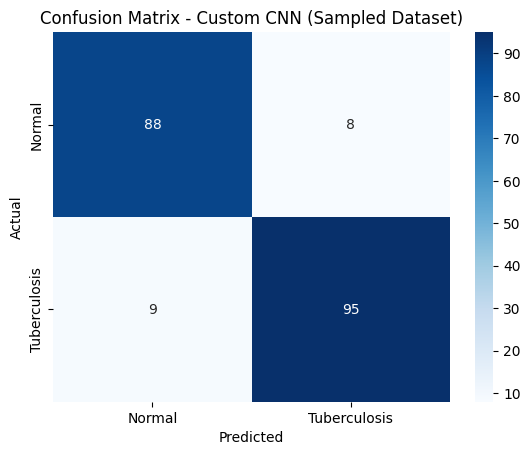

Training VGG16 (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step - accuracy: 0.6504 - loss: 1.4289 - recall: 0.6139 - val_accuracy: 0.8750 - val_loss: 0.3929 - val_recall: 0.7692
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.8583 - loss: 0.3976 - recall: 0.8430 - val_accuracy: 0.9400 - val_loss: 0.3301 - val_recall: 0.9519
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.9110 - loss: 0.3753 - recall: 0.9172 - val_accuracy: 0.9100 - val_loss: 0.3372 - val_recall: 0.8558
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.9065 - loss: 0.3520 - recall: 0.9001 - val_accuracy: 0.9250 - val_loss: 0.3255 - val_recall: 0.8654
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.9252 - loss: 0.3473 - recall: 0.9084 - val_accuracy: 0.9500 - val_loss: 0.3044 - val_recall: 0.9231
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.9175 - loss: 0.3532 - recall: 0.9154 - val_accuracy: 0.9650 - val_loss: 0.2859 - val_recall: 0.9615
Epoch 7/20
25/

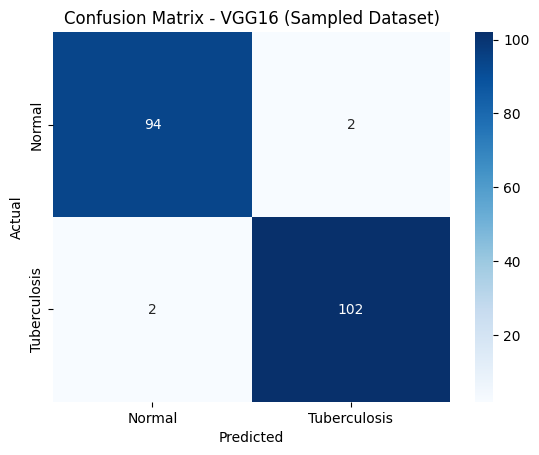

Training DenseNet201 (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6944 - loss: 6.9556 - recall: 0.6873 - val_accuracy: 0.9250 - val_loss: 0.5902 - val_recall: 0.8654
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.8563 - loss: 0.6436 - recall: 0.7857 - val_accuracy: 0.9700 - val_loss: 0.2989 - val_recall: 0.9904
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.9249 - loss: 0.3602 - recall: 0.9182 - val_accuracy: 0.9650 - val_loss: 0.2971 - val_recall: 0.9327
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.9141 - loss: 0.3746 - recall: 0.9021 - val_accuracy: 0.9450 - val_loss: 0.2986 - val_recall: 0.9038
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.9385 - loss: 0.3238 - recall: 0.9102 - val_accuracy: 0.9650 - val_loss: 0.2799 - val_recall: 0.9327
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.9353 - loss: 0.3317 - recall: 0.9156 - val_accuracy: 0.9750 - val_loss: 0.2686 - val_recall: 0.9615
Epoch 7/20
25/25 

7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
Classification Report for DenseNet201 (Sampled Dataset):
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98        96
Tuberculosis       0.99      0.97      0.98       104

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



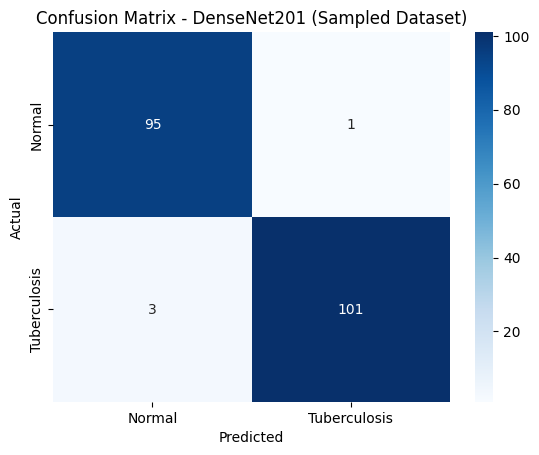

Training ResNet101 (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 671ms/step - accuracy: 0.5058 - loss: 6.8173 - recall: 0.4717 - val_accuracy: 0.5200 - val_loss: 0.7225 - val_recall: 1.0000
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.5154 - loss: 0.7254 - recall: 0.5570 - val_accuracy: 0.4800 - val_loss: 0.6956 - val_recall: 0.0000e+00
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.4968 - loss: 0.6942 - recall: 0.3889 - val_accuracy: 0.5150 - val_loss: 0.6922 - val_recall: 0.0769
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.5263 - loss: 0.6917 - recall: 0.5434 - val_accuracy: 0.6450 - val_loss: 0.6926 - val_recall: 0.8173
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.4624 - loss: 0.6931 - recall: 0.9477 - val_accuracy: 0.5200 - val_loss: 0.6931 - val_recall: 1.0000
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.4957 - loss: 0.6932 - recall: 0.9995 - val_accuracy: 0.5200 - val_loss: 0.6931 - val_recall: 1.0000
Epoch 7/20

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 957ms/step
Classification Report for ResNet101 (Sampled Dataset):
              precision    recall  f1-score   support

      Normal       0.50      0.99      0.66        96
Tuberculosis       0.89      0.08      0.14       104

    accuracy                           0.52       200
   macro avg       0.69      0.53      0.40       200
weighted avg       0.70      0.52      0.39       200



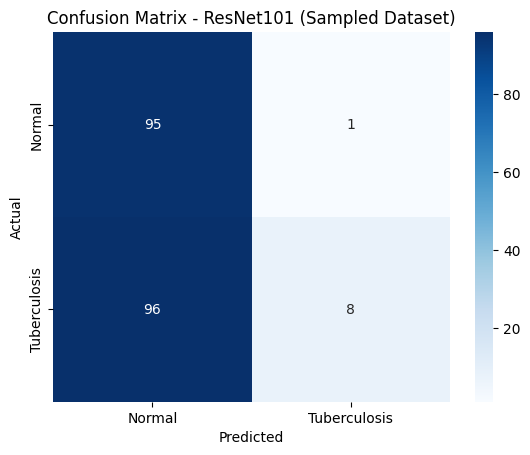

In [18]:
### 6. Model Training
# Define input shape and number of classes
input_shape = (image_size, image_size, 3)
num_classes = len(labels)

# Custom Model
custom_model_sampled = build_custom_model(input_shape, num_classes)
custom_history_sampled = train_and_evaluate_model(custom_model_sampled, "Custom CNN (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

# VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_model_sampled = build_pretrained_model(vgg16_base, input_shape, num_classes)
vgg16_history_sampled = train_and_evaluate_model(vgg16_model_sampled, "VGG16 (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

# DenseNet201
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_model_sampled = build_pretrained_model(densenet_base, input_shape, num_classes)
densenet_history_sampled = train_and_evaluate_model(densenet_model_sampled, "DenseNet201 (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

# ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_model_sampled = build_pretrained_model(resnet_base, input_shape, num_classes)
resnet_history_sampled = train_and_evaluate_model(resnet_model_sampled, "ResNet101 (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

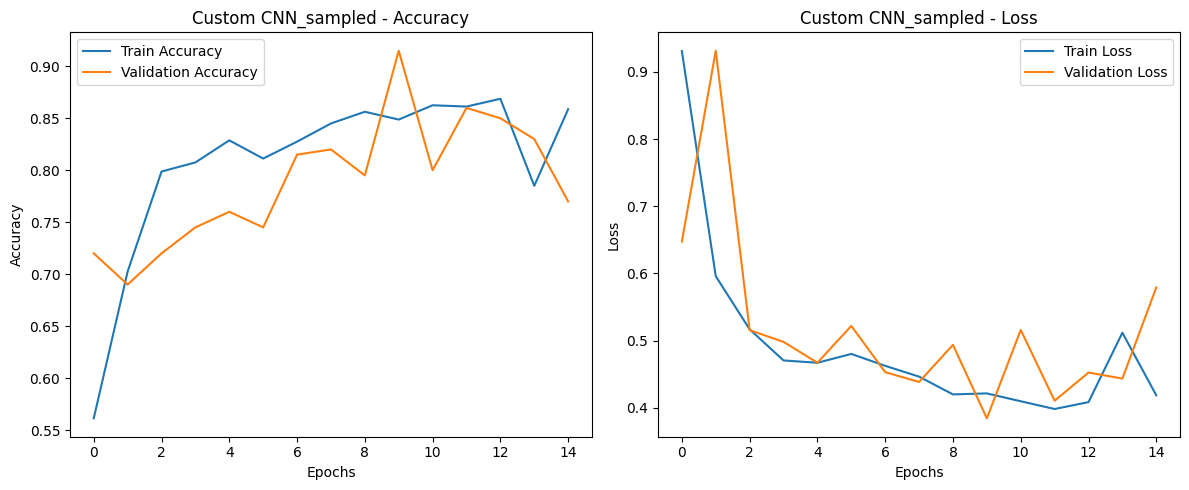

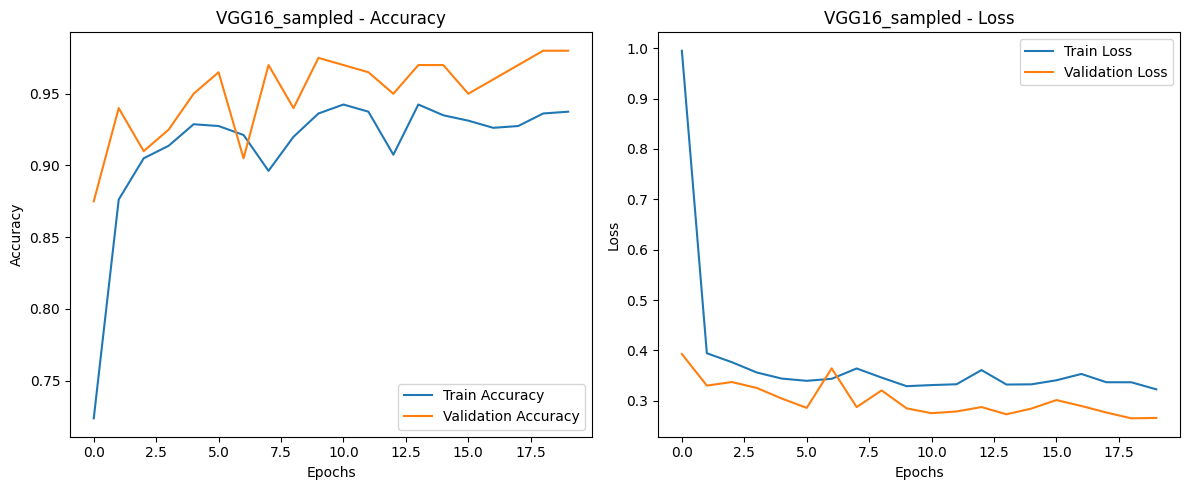

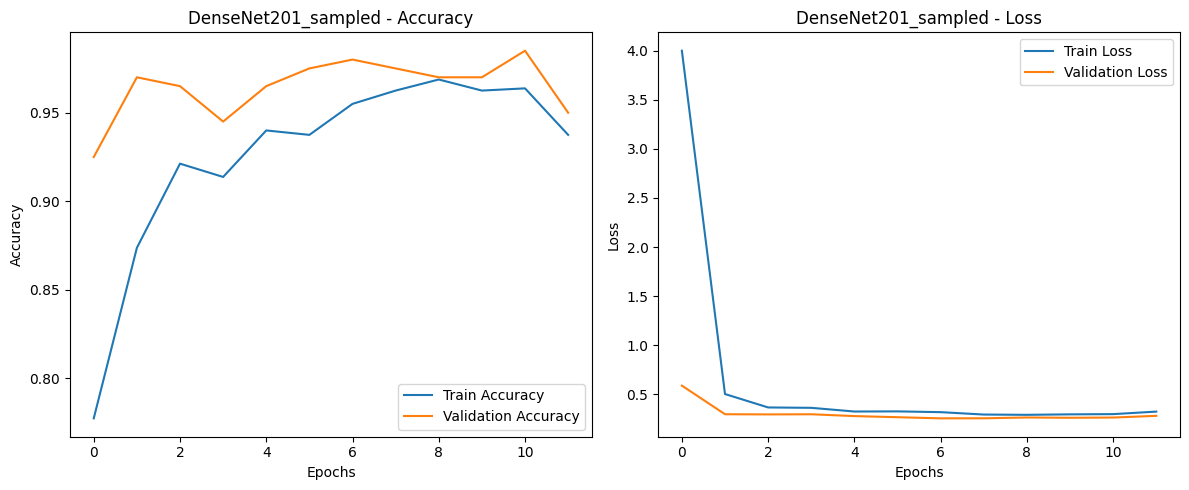

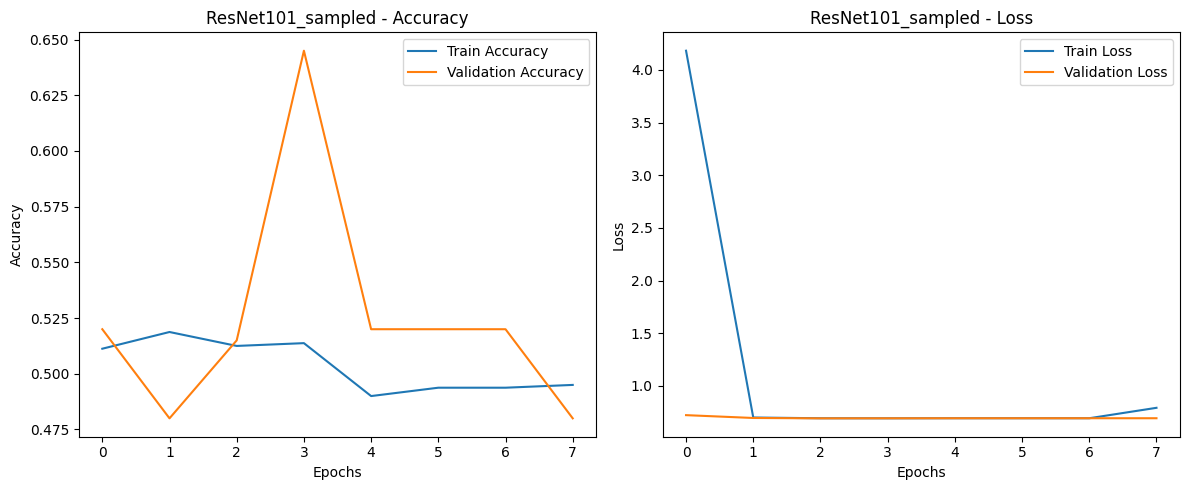

In [19]:
# 7 Plot individual models
models = {
    "Custom CNN_sampled": custom_history_sampled,
    "VGG16_sampled": vgg16_history_sampled,
    "DenseNet201_sampled": densenet_history_sampled,
    "ResNet101_sampled": resnet_history_sampled
}

for model_name, history in models.items():
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Predictions for Sampled Dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


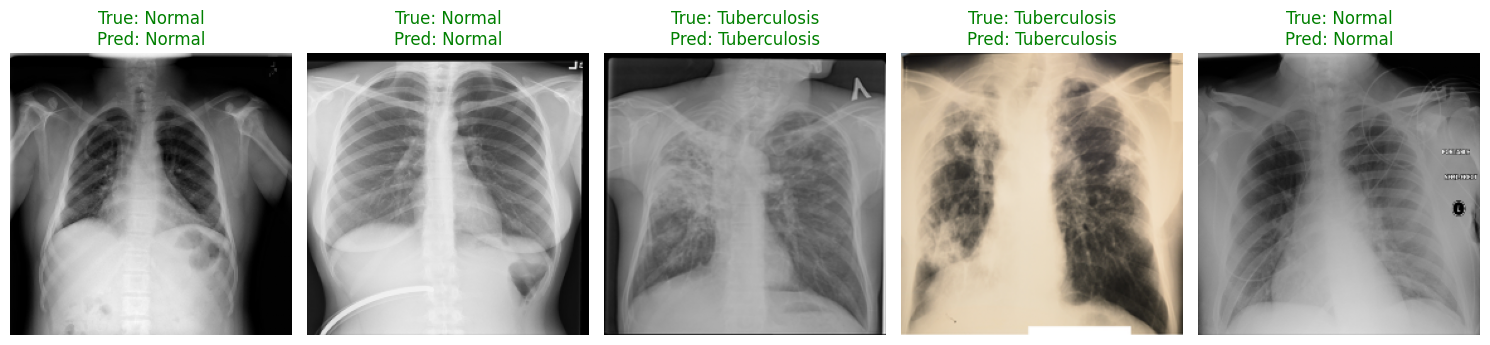

In [20]:
### 8. Predict and Display Images
# Function to display predictions for 5 random images
def display_predictions(model, x_test, y_test, labels, num_images=5):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        img = x_test[idx]
        true_label = labels[np.argmax(y_test[idx])]
        pred_label = labels[np.argmax(model.predict(img[np.newaxis, ...]))]
        color = 'green' if true_label == pred_label else 'red'
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
print("Predictions for Sampled Dataset")
display_predictions(custom_model_sampled, x_test_sampled, y_test_sampled, labels, num_images=5)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


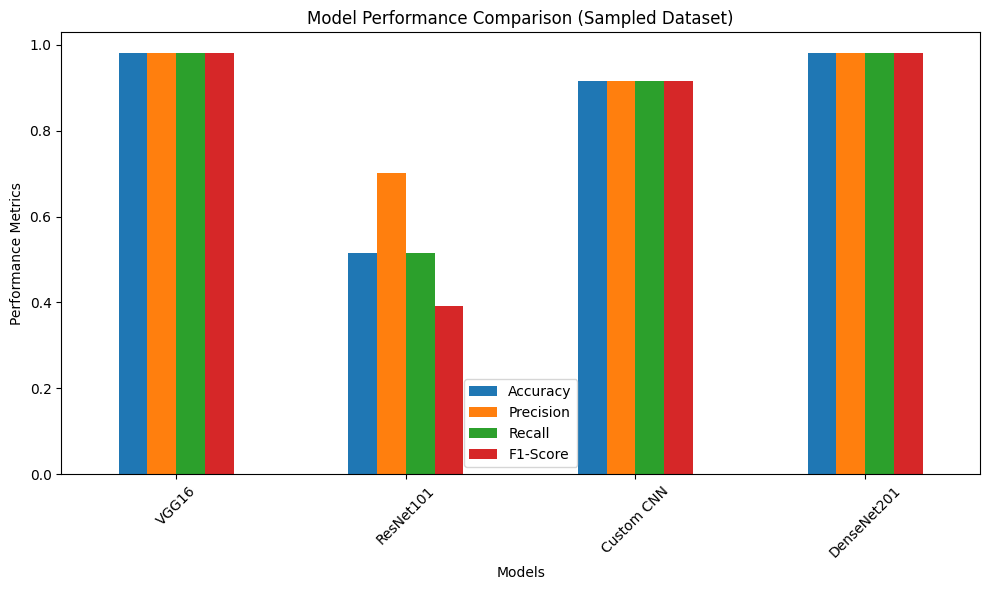

In [21]:
# 9 Predictions for each individual model
vgg_preds_sampled = np.argmax(vgg16_model_sampled.predict(x_test_sampled), axis=1)
resnet_preds_sampled = np.argmax(resnet_model_sampled.predict(x_test_sampled), axis=1)
custom_preds_sampled = np.argmax(custom_model_sampled.predict(x_test_sampled), axis=1)
densenet_preds_sampled = np.argmax(densenet_model_sampled.predict(x_test_sampled), axis=1)

# True labels
y_true_sampled = np.argmax(y_test_sampled, axis=1)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}



# Evaluate models for the sampled dataset
results_sampled = []
results_sampled.append(evaluate_model(y_true_sampled, vgg_preds_sampled, "VGG16"))
results_sampled.append(evaluate_model(y_true_sampled, resnet_preds_sampled, "ResNet101"))
results_sampled.append(evaluate_model(y_true_sampled, custom_preds_sampled, "Custom CNN"))
results_sampled.append(evaluate_model(y_true_sampled, densenet_preds_sampled, "DenseNet201"))


# Convert results to DataFrames for comparison
results_sampled_df = pd.DataFrame(results_sampled)

# Bar plot for the sampled dataset
results_sampled_df.set_index("Model").plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison (Sampled Dataset)")
plt.xlabel("Models")
plt.ylabel("Performance Metrics")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()
